In [ ]:
파이토치로 시작하는 딥러닝 입문책 기반.

# CNN(합성곱 신경망)

MLP로 이미지를 처리하면 객체가 완전히 다른 벡터로 변환돼 객체의 공통된 특성을 뽑아내지 못할 수 있다.

따라서 전체 이미지를 벡터화하지 않고 이미지의 일부분을 살펴 전체 이미지를 해석: CNN

## AlexNet

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
#CIFAR10 데이터세트 불러오기
#transforms, Normalize는 특정 평균과 표준편차를 따르는 정규분포를 통해 이미지 표준화
#CIFAR10은 3컬러 이미지이므로 각 장의 평균과 표준편차를 정한다. (0.5,0.5,0.5)
#두번째는 각 채널의 표준편차 기입

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
def imshow(img):
    img = .5*img + .5
    plt.figure(figsize=(10,100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

images, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(images,nrow=8))
print(images.size()) # 배치 및 이미지 크기 확인

In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

In [ ]:
#AlexNet 구축하기
#Alexnet은 imagenet을 위해 만들어졌다. Imagenet은 1000개의 클래스, 256x256의 크기이므로 32x32인 CIFAR10의 필터의 크기와 보폭 수 조정

# Conv→ReLU→MaxPool→ Conv→ReLU→MaxPool→Conv→ReLU→ Conv→ReLU→Conv→ReLU→MaxPool→FC1→ReLU→FC2→ReLU→FC3

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
                        nn.Conv2d(3, 64, 3), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(256, 256, 1), nn.ReLU(),
                        nn.MaxPool2d(2, 2)        
                        )
        
        
        self.classifier = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(256*3*3, 1024), nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(1024, 512), nn.ReLU(),
                        nn.Linear(512, 10) #10개의 클래스를 지녔기에 마지막 노드 수는 10
                        )    
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256*3*3)
        x = self.classifier(x)    
        return x

alexnet = AlexNet().to(device) # 모델 선언

In [ ]:
#손실함수 및 최적화 정의
criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(),lr=1e-3)

In [ ]:
#모델 학습하기
loss_ = []
n = len(trainloader)

for epoch in range(50):  # 10번 학습을 진행한다.

    running_loss = 0.0
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 
        
        optimizer.zero_grad()
        outputs = alexnet(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    loss_.append(running_loss / n)    
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))

# RNN(순환 신경망)

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

df = pd.read_csv("/Users/jihyeonbin/Pytorch_sample/data/kospi.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [4]:
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


사용할 데이터는 인스턴스가 413개이고 피처가 4개, 타깃값은 종가(Close)이다.

In [7]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cpu is available.


In [8]:
X = df[['Open','High','Low','Volume']].values #입력 데이터 생성
y = df['Close'].values #타깃 데이터 생성

In [9]:
def seq_data(x, y, sequence_length):
    
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length]) # a[2:6] -> 2,3,4,5
        y_seq.append(y[i+sequence_length])
    
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1) 
    #GPU용 텐서로 변환. y데이터를 2차원으로 바꾸는 이유는 MSE Loss가 기본적으로 2차원 타깃 데이터를 받는다.

In [10]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


<ipython-input-9-29ca4ee4036f>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484782168/work/torch/csrc/utils/tensor_new.cpp:204.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)


In [11]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
#dataset으로 바꾸고

batch_size = 20

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [12]:
#RNN 구축에 필요한 하이퍼파라미터 정의
input_size = x_seq.size(2) #입력 변수의 개수
num_layers = 2 #은낵츠으이 개수
hidden_size = 8

RNN 구축

In [13]:
class VanillaRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.device =device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid()) #출력값이 FC하나 거쳐 예측값 뽑도록 FC설정
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state는 0
        out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로 부터 나온 output feature 반환, hn: hidden state 반환, _는 함수의 반환값을 받지 않을 때 사용한다.
        out = out.reshape(out.shape[0], -1) # many to many 전략
        out = self.fc(out)
        return out

In [14]:
model = VanillaRNN(input_size=input_size, 
                   hidden_size=hidden_size, 
                   sequence_length=sequence_length, 
                   num_layers=num_layers, 
                   device=device).to(device)

In [15]:
criterion = nn.MSELoss()
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr=1e-3)

모델 학습하기

In [16]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for data in train_loader:
        
        seq,target = data #배치 데이터
        out = model(seq) #출력값 산출
        loss = criterion(out,target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0283
[epoch: 100] loss: 0.0009
[epoch: 200] loss: 0.0005
[epoch: 300] loss: 0.0005


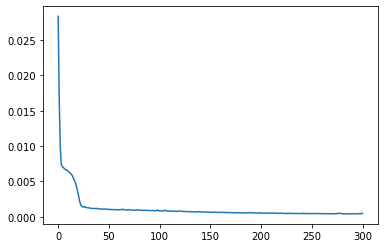

In [17]:
#손실함수값 그려보자
plt.plot(loss_graph)

주가 그리기

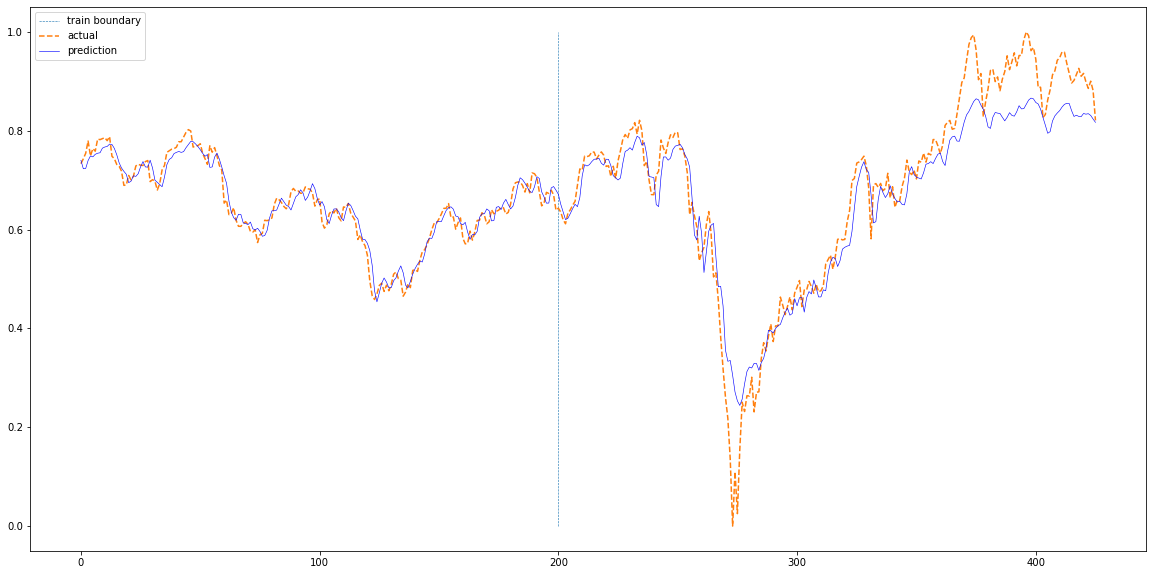

In [18]:
concatdata = torch.utils.data.ConcatDataset([train,test]) #여러개의 데이터셋 함꼐 사용할 수 있도록 한다.
data_loader = torch.utils.data.DataLoader(dataset = concatdata,batch_size=100)
with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq,target = data
        out = model(seq)
        pred += out.cpu().tolist() #에측값인 GPU텐서 CPU로 변환 후 리스트로 이어붙인다
        
plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6) #학습 일수와 평가 일수를 구분짓는 선 그린다.
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show() 

# LSTM과 GRU

RNN은 시퀀스의 길이가 길거나 관련 정보들 간의 거리가 멀면 학습 능력이 크게 하락할 수 있따. 

RNN의 단점을 보완한 것이 LSTM

LSTM 간소화한 GRU

LSTM은 RNN을 보관하고자 셀 상태 s와 모든 값이 0과1사이인 입력 게이트, 망각게이트, 출력게이트를 추가해 이전 정보와 현재 정보의 비중을 조절하여 예측에 반환

nn.LSTM 사용 시 내부 계산 별도 필요 없고 W와 U들이 자동 관리된다.

In [20]:
#모델 구축하기(모델구축 외 다른부분은 RNN과 동일)
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) #애를 통해 한줄로 정의 가능
        self.fc = nn.Linear(hidden_size*sequence_length, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #은닉상태와 셀 상태의 초깃값은 0으로 하여 모델에 대입
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # <- cell state 추가
        out, _ = self.lstm(x, (h0, c0)) # output, (hn, cn): cell state와 hidden state만 반환
        out = out.reshape(out.shape[0], -1) # <- state 추가
        out = self.fc(out)
        return out

In [21]:
#GRU: 셀 상태 없애고 2개의 데이터만 사용해 간소화한다. 
#모델구축 외 다은 부분은 동일

In [22]:
class GRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(GRU, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*sequence_length, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1) # <- state 추가
        out = self.fc(out)
        return out

# Bi-LSTM

Bi-LSTM, 즉 양방향 LSTM은 순방향과 역방향의 연산을 담당하는 은닉층을 각각두어 서로 다른 방향에 대해 계산 수행

정방향, 역방향에 관한 연산 각각 수행해 두 결과 합쳐 은닉층의 결과로 만든다.

In [24]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [25]:
#MNIST 이미지 판별 해보자
#MNIST의 채널수는 1, 이미지난 28x28
#이때 크기는 (배치사이즈, 28, 28)
#이미지 픽셀을 각 열을 벡터로 보고 행을 타임 스텝으로 본다면(배치사이즈, 시계열 길이, 벡터의 크기) 를 지닌 식계열 데이터라 할 수 있따.
# Load Data
tensor_mode = torchvision.transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=tensor_mode, download=True)
testset = torchvision.datasets.MNIST(root="./data", train=False, transform=tensor_mode, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


/Users/jihyeonbin/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484782168/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


In [29]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, num_classes, device):
        super(BiLSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size,hidden_size, num_layers,batch_first = True, bidirectional= True) #양방향 생성함.
        self. fc = nn.Linear(seq_length * hidden_size *2,num_classes) #모든 타임 스탭에 대한 LSTM 결과 사용, 양방향이므로 2 곱한다.
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        #out = self.fc(out[:, -1, :]) #out 크기는 (배치사이즈, 시계열의 길이, 은닉층의 노드수 *2) 이므로 reshape하고 self.fc 거쳐 크기가 10인 출력벡터
        out = out.reshape(-1,self.seq_length*self.hidden_size * 2)
        out = self.fc(out)
        return out

In [30]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = trainset.data.size(1)
input_size = trainset.data.size(2)
num_layers = 2
hidden_size = 12
num_classes = 10

In [31]:
model = BiLSTM(input_size, hidden_size, num_layers, sequence_length, num_classes, device)
model = model.to(device)   

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [32]:
#모델 학습하기
for epoch in range(51):
    correct = 0
    total = 0
    for data in trainloader:
        optimizer.zero_grad()
        inputs, labels = data[0].to(device).squeeze(1), data[1].to(device)  #원래 데이터의 배치 사이즈를 줄인다.
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.detach(), 1) #학습 도중 정확도를 구할떄는 변수 업데이트가 필요 없다. 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('[%d] train acc: %.2f' %(epoch, 100*correct/total))     

[0] train acc: 91.50
[1] train acc: 97.63
[2] train acc: 98.23
[3] train acc: 98.60
[4] train acc: 98.72
[5] train acc: 98.85
[6] train acc: 99.07
[7] train acc: 99.08
[8] train acc: 99.16
[9] train acc: 99.27


KeyboardInterrupt: 